# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[Kaggle source](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction)
This dataset contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance. I'll try to build a model that predicts this decision.

In [1]:
from common import *

print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization
TODO

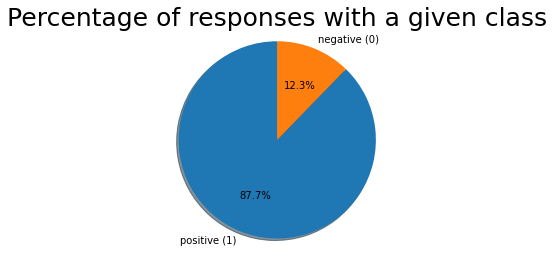

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

There are much more (87,7%) people witch choose both insurances.

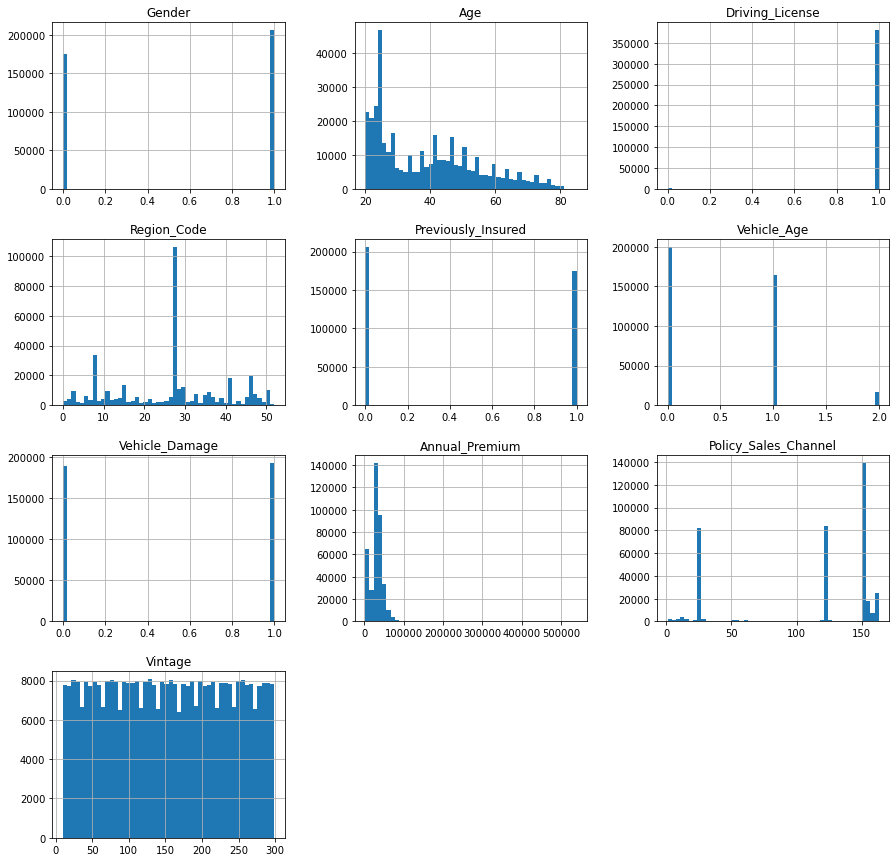

In [3]:
X_le.hist(bins=50, figsize=(15, 15))
plt.show()

TODO: conclusions from histogram

## 3. Basic model with logistic regression
TODO

### 3.1 Metric
TODO: linguistically improve the paragraph
This problem is an example of an "imbalanced dataset". It means that one class ("negative"/"zeroes" in this article) has significantly more samples than the others. You can get 87.7% accuracy... just by assigning the same prediction to all cases. There are more reliable metrics for imbalanced datasets - one of them is ROC AUC.

#### 3.1.1 True positive rate, False positive rate
For proper understanging of ROC AUC metric it is necessary first to explain TPR (true positive rate) and FPR (false positive rate).

True positive rate is number of proper predicted positive cases divided by all positive cases. For example - if there are 10.000 customers which choosed an insurance and our model found 9.500 of them - TPR equals 9.500/10.000 = 95%

False positive rate is number of false predicted positive cases divided by all negative cases. For example - if there are 100.000 customers which didn't choose an insurance and our model predicted that 1.000 of them choosed it - FPR equals 1.000/100.000 = 1%

#### 3.1.2 Receiver operating characteristic
Usually we can set threshold describing how sure the algorithm need to be to predict the result for single sample as "true". There is TPR on vertical axis and FPR on horizontal axis and the ROC curve is created by plotting points for consecutive thresholds.

#### 3.1.3 ROC Area under curve
It could be hard to simple compare various ROC curves. For this purpose I'll use the final metric - ROC AUC (area under curve). The alhorithm will calculate area under ROC curve - it's much easier to compare single numbers.


### 3.2 Cross validation
Cross validation is a way of measuring model performance. It divides all the data into a given number of parts. Later in each iteration, one part is used as validation data and the rest as training data. Each part was used as test data after all iterations. This method gives more reliable measurements than standard one-step validation.

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, n_jobs=-1)
cross_val_summary(logreg, X_le, y)

Cross validation time: 21.34451174736023 seconds
Mean score: 0.6626219144051005


## 4. Simple model with Light GBM
TODO

In [2]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
cross_val_summary(lgbm, X_le, y)

Cross validation time: 3.729891300201416 seconds
Mean score: 0.8575017665775645


## 5 Remove 'Vintage' column

TODO: add description

In [6]:
cross_val_summary(lgbm, X_le.drop(columns="Vintage"), y, message="Mean ROC_AUC without 'Vintage' column: ")

Cross validation time: 3.272094249725342 seconds
Mean ROC_AUC without 'Vintage' column: 0.8577693288099889


## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

TODO: add description

In [7]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# TODO: determine which model returns log about scaling/more iterations
def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)

    cross_val_summary(model, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

compare_preprocessing(lgbm, X_le.drop(columns="Vintage"), y)

Cross validation time: 3.299079179763794 seconds
Mean ROC_AUC score without scaler: 0.8577693288099889
Cross validation time: 3.50941801071167 seconds
Mean ROC_AUC score with scaler: 0.8574143509437648


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healt

Cross validation time: 19.19187307357788 seconds
Mean ROC_AUC score with transformer: 0.8577319440867275
Cross validation time: 22.24144411087036 seconds
Mean ROC_AUC score with scaler and transformer: 0.8577400779770201
Cross validation time: 5.565432548522949 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576643396361232
Cross validation time: 6.502594232559204 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8576585510190945


The differences between various scaling methods are small, so I need to make more tests after the next steps.

## 8. Policy_Sales_Channel One Hot Encoding

"Policy_Sales_Channel" is a categorical column. Algorithms cannot always effectively use this type of data in a single column. For example, channel 2 is not "smaller" than channel 4, and channel 3 is not "between" them in a mathematical sense. There are some tools addressing this problem. For now I'll use One Hot Encoding. It creates a new column for each of the categories and fills it with 1 if the sample falls into that category and with 0 if it does not.

In [8]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.652437448501587 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 17.13546371459961 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/js

Cross validation time: 299.45684337615967 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_tra

Cross validation time: 414.3436620235443 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 23.52898359298706 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 36.257479190826416 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577135371381092


I checked - it works worse with dropped original Policy_Sales_Channel column

Unfortunately, there are 155 distinct categories. Considering almost 400.000 samples and complex algorithm - this step seriosly slows down training. Additionaly - it generates a lot of column with few "ones" and several hundred thousand "zeros".

How to curb this problem?

If given policy sales channel occurs only once in the whole dataset, it can't be used to predict other samples. At first I will eliminate such categories.

In [9]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.543667793273926 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 16.693971633911133 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/h

Cross validation time: 283.97425365448 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Cross validation time: 394.5038664340973 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 22.755218982696533 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 35.103058099746704 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8576189364379558


In [7]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
X_le_psc["Policy_Sales_Channel"].value_counts()

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
143.0         1
43.0          1
41.0          1
84.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,

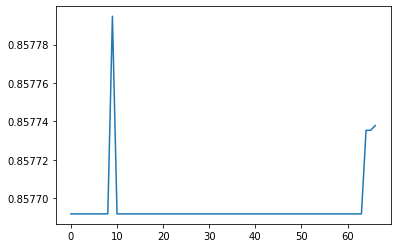

In [58]:
# X_le_psc["Policy_Sales_Channel"].value_counts().index[147]

from sklearn.preprocessing import QuantileTransformer
import warnings
warnings.filterwarnings("ignore")

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
value_counts[147]
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 80, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
#     X_le_psc.drop(columns=columns_to_remove)
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

In [60]:
scores_series.sort_values()

49    0.857692
61    0.857692
58    0.857692
19    0.857692
55    0.857692
        ...   
24    0.857692
65    0.857735
64    0.857735
66    0.857738
9     0.857795
Length: 67, dtype: float64

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,

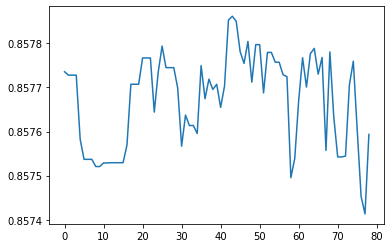

In [61]:
# X_le_psc["Policy_Sales_Channel"].value_counts().index[147]

from sklearn.preprocessing import QuantileTransformer
import warnings
warnings.filterwarnings("ignore")

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
value_counts[147]
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores2 = []

iteration = 0
print('Done iterations: ', end='')
for x in range(80, 1, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
#     X_le_psc.drop(columns=columns_to_remove)
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores2 += [score]
    print(str(iteration) + ",", end='')

scores_series2 = pd.Series(scores2)
plt.plot(scores_series2.index, scores_series2.values)

In [62]:
scores_series2.sort_values()

77    0.857413
76    0.857453
58    0.857495
8     0.857521
9     0.857521
        ...   
50    0.857797
47    0.857804
44    0.857850
42    0.857853
43    0.857862
Length: 79, dtype: float64

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,

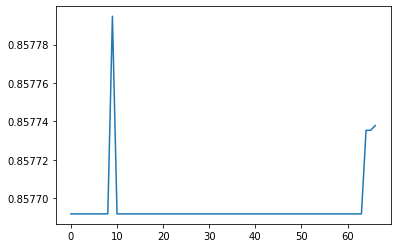

In [64]:
# X_le_psc["Policy_Sales_Channel"].value_counts().index[147]

from sklearn.preprocessing import QuantileTransformer
import warnings
warnings.filterwarnings("ignore")

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
value_counts[147]
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 1, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
#     X_le_psc.drop(columns=columns_to_remove)
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series3 = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

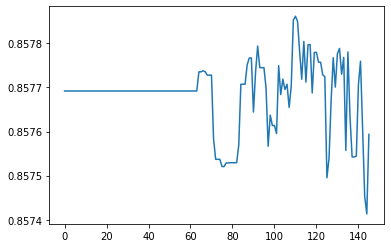

In [67]:
plt.plot(scores_series3.index, scores_series3.values)

In [65]:
scores_series3.sort_values()

144    0.857413
143    0.857453
125    0.857495
75     0.857521
76     0.857521
         ...   
116    0.857797
114    0.857804
111    0.857850
109    0.857853
110    0.857862
Length: 146, dtype: float64

In [66]:
scores_series3

0      0.857692
1      0.857692
2      0.857692
3      0.857692
4      0.857692
         ...   
141    0.857760
142    0.857604
143    0.857453
144    0.857413
145    0.857593
Length: 146, dtype: float64

## TargetEncoding on Region_Code

In [11]:
from category_encoders import TargetEncoder

def compare_preprocessing_te(model, X, y, te_columns):
    encoder = TargetEncoder(cols=te_columns)

    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_te = make_pipeline(encoder, model)
    model_scaler = make_pipeline(encoder, scaler, model)
    model_transformer = make_pipeline(encoder, transformer, model)
    model_scaler_transformer = make_pipeline(encoder, scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(encoder, quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(encoder, quant_trans_normal, model)

    cross_val_summary(model_te, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

X_le_psc_te = X_le_psc.copy()
X_le_psc_te['Region_Code_te'] = X_le_psc_te['Region_Code']

compare_preprocessing_te(lgbm, X_le_psc_te.drop(columns="Vintage"), y, ['Region_Code_te'])

/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

Cross validation time: 8.050952434539795 seconds
Mean ROC_AUC score without scaler: 0.8579067916687162


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

Cross validation time: 17.94546604156494 seconds
Mean ROC_AUC score with scaler: 0.8578644642287532


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_me

Cross validation time: 287.2157678604126 seconds
Mean ROC_AUC score with transformer: 0.857810827674418


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/hea

Cross validation time: 396.45464539527893 seconds
Mean ROC_AUC score with scaler and transformer: 0.8579116254040393


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

Cross validation time: 24.58550500869751 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8580732487032112


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

Cross validation time: 36.83420467376709 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8579274467170059


About 0.0006 ROC_AUC point boost.